## Data Importing

In [ ]:
import numpy as np
from energyflow.utils import to_categorical
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import json

In [ ]:
# Import Data
inputfile = '../OT/LinW2_WQCD10k_centered.npz'
npzfile = np.load(inputfile)
npzfile.files

['X', 'Y', 'uniref', 'ref_pts', 'bary_list', 'linearCoord_list']

In [ ]:
datasize = 1000
X_centered = npzfile['X'][:datasize]
Y = npzfile['Y'][:datasize]
linearCoord_list_centered = npzfile['linearCoord_list'][:datasize]

linearCoord_list_centered.shape, X_centered.shape, Y.shape

((1000, 100, 2), (1000, 217, 3), (1000, 2))

In [ ]:
# Reshape the coord so that we have x = (x_Y, x_phi).T
linearCoord_list_centered = linearCoord_list_centered.reshape((datasize, linearCoord_list_centered.shape[1]*linearCoord_list_centered.shape[2]))
linearCoord_list_centered.shape

(1000, 200)

## train/val/test split

In [ ]:
train, val, test = 500, 250, 250
linearCoord_train_centered, linearCoord_val_centered, linearCoord_trainval_centered, linearCoord_test_centered = linearCoord_list_centered[:train], linearCoord_list_centered[train:train+val], linearCoord_list_centered[:train+val], linearCoord_list_centered[train+val:]
Y_train, Y_val, Y_trainval, Y_test = Y[:train], Y[train:train+val], Y[:train+val], Y[train+val:]

## kNN for X_centered

In [ ]:
# Number of neighborhoods.
neighs = list(range(10, 200, 10))

In [ ]:
models, preds_val = [], []
for neigh in neighs:
    print("Processing neighbor k=", neigh)
    model = KNeighborsClassifier(n_neighbors=neigh)
    model.fit(linearCoord_train_centered, Y_train)
    pred_val = model.predict(linearCoord_val_centered)
    models.append(model)
    preds_val.append(pred_val)

Processing neighbor k= 10
Processing neighbor k= 20
Processing neighbor k= 30
Processing neighbor k= 40
Processing neighbor k= 50
Processing neighbor k= 60
Processing neighbor k= 70
Processing neighbor k= 80
Processing neighbor k= 90
Processing neighbor k= 100
Processing neighbor k= 110
Processing neighbor k= 120
Processing neighbor k= 130
Processing neighbor k= 140
Processing neighbor k= 150
Processing neighbor k= 160
Processing neighbor k= 170
Processing neighbor k= 180
Processing neighbor k= 190


In [ ]:
aucs_val = []
for i, pred in enumerate(preds_val):
    auc = roc_auc_score(Y_val[:,1], pred[:,1])
    aucs_val.append(auc)

In [ ]:
# Find the # of neighbors that give the biggest AUC.
max_indices = [i for i, j in enumerate(aucs_val) if j == max(aucs_val)]
best_neighs = [neighs[i] for i in max_indices]
print('The best # of neighbors are: ', best_neighs)

The best # of neighbors are:  [10]


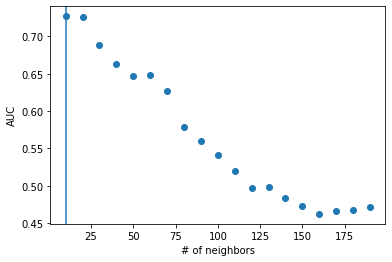

In [ ]:
# Plot AUC as a function of # of neighbors
plt.scatter(neighs, aucs_val)
for xc in best_neighs:
    plt.axvline(x=xc)
plt.xlabel("# of neighbors")
plt.ylabel("AUC")
plt.show()

In [ ]:
# Choose the smallest number as our best number of neighbors
best_neigh = min(best_neighs)
best_neigh

10

In [ ]:
# Build the model for best_neigh using train+val as the training data
best_model = KNeighborsClassifier(n_neighbors=best_neigh)
best_model.fit(linearCoord_trainval_centered, Y_trainval)
pred_test = best_model.predict(linearCoord_test_centered)
pred_test_proba = best_model.predict_proba(linearCoord_test_centered)

In [ ]:
best_auc = roc_auc_score(Y_test[:,1], pred_test[:,1])
print('The AUC for the best_neigh model is: ', best_auc)

The AUC for the best_neigh model is:  0.7471153846153846


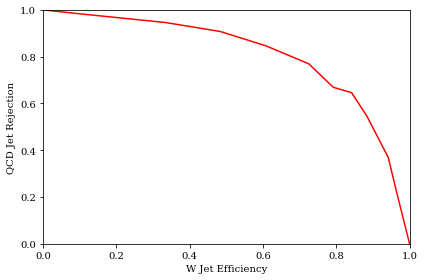

In [ ]:
# Plot ROC for best_neigh
fp, tp, threshs = roc_curve(Y_test[:,1], pred_test_proba[1][:,1])

# some nicer plot settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves for pfn
plt.plot(tp, 1-fp, '-', color='red')

# axes labels
plt.xlabel('W Jet Efficiency')
plt.ylabel('QCD Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.show()

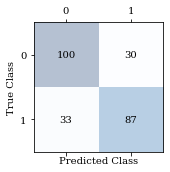

In [ ]:
confmat = confusion_matrix(y_true=Y_test[:,1], y_pred=np.array(pred_test)[:,1])
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [ ]:
TN, FP, FN, TP = confusion_matrix(y_true=Y_test[:,1], y_pred=np.array(pred_test)[:,1]).ravel()
TPR = TP / (TP + FN)
FPR = FP /(FP + TN)
print('TPR: ', TPR)
print('FPR: ', FPR)
print('AUC: ', best_auc)

TPR:  0.725
FPR:  0.23076923076923078
AUC:  0.7471153846153846


In [ ]:
# with open('kNN.json', 'r') as f:
#     result = json.load(f)

In [ ]:
# result["LinW2_uniref10"]["3subjets"] = {"k": best_neigh, "AUC": np.round(best_auc, 3)}

In [ ]:
# result

In [ ]:
# with open('kNN.json', 'w') as f:
#     json.dump(result, f,  indent=4)